In [1]:
import cv2, sys, os, time
import numpy as np
import pickle
import matplotlib.pyplot as plt 

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from utils.detection_tools import extract_object_and_background_masks
from utils.detection_tools import detect_sky, estimate_horizon_line_by_edges
from utils.detection_tools import rectify_horizon, downsampler, rotate_and_center_horizon
from utils.common_tools import annotate_image, show_bgr
from utils.common_tools import find_nonzero_bounding_box, trim_video, draw_parallel_lines

from utils.detection_tools import get_min_max_hsv, extract_contour_region
from auto_startup.config import ImageProcessingParams
from utils.detection_tools import detect_sky, estimate_horizon_line_by_edges
from utils.detection_tools import  downsampler, rotate_and_center_horizon
from utils.common_tools import annotate_image, show_bgr, draw_parallel_lines
from utils.detection_tools import get_min_max_lab_values, create_wide_donut_mask
from src.detect_basic import detect_basic




In [2]:
## Input 1: input pic of O & B
## Input 2: get live stream, get picture of O+B
## Input 3: input pic of O, get live stream of B
## Statement: There is one discrete target here. Find it. 
## get B col, O col, O size, location, pass option
##
## Process
##
##

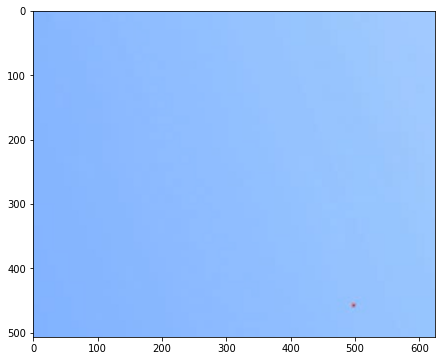

In [3]:
# load in foi_2.png with opencv

frame = cv2.imread('foi_2.png')
#frame = frame[0:200,0:600] #for foi_2b




show_bgr(frame,w=10)

HSV Values
{'min_h': 117, 'max_h': 166, 'min_s': 46, 'max_s': 114, 'min_v': 126, 'max_v': 211}


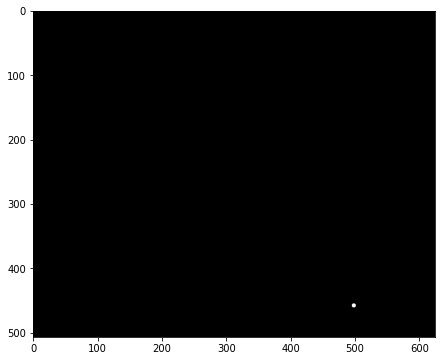

In [4]:
complete_frame, x,y,w,h, contour_mask, identified_object = detect_basic(frame,1,debug=False,debug_image_width=20)
show_bgr(contour_mask,w=10)

495 455 6 6


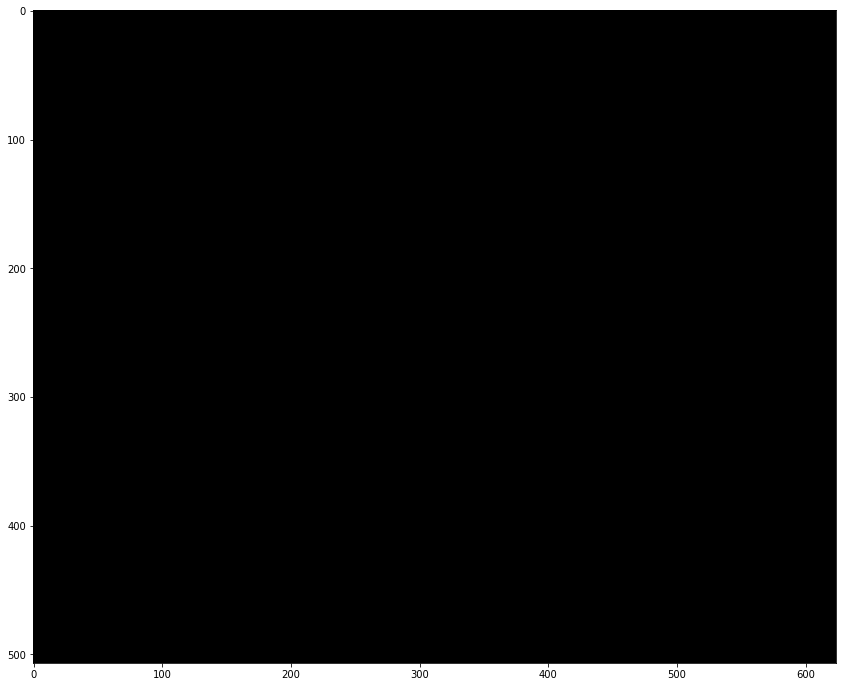

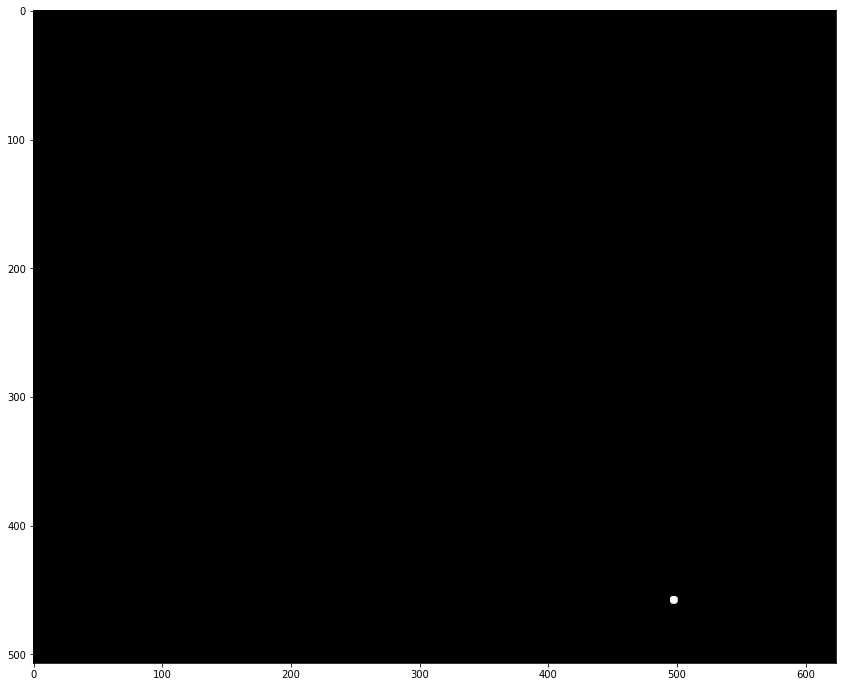

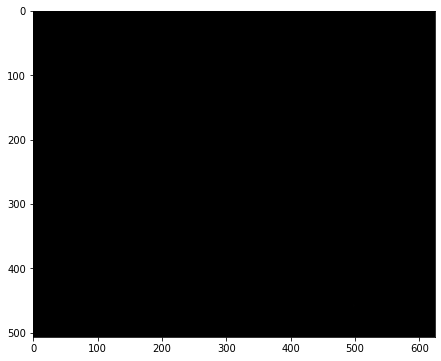

In [ ]:

min_vals, max_vals = get_min_max_lab_values(frame, contour_mask)


background_mask = create_wide_donut_mask(frame,identified_object,padding_ratio=4)
show_bgr(background_mask,w=10)

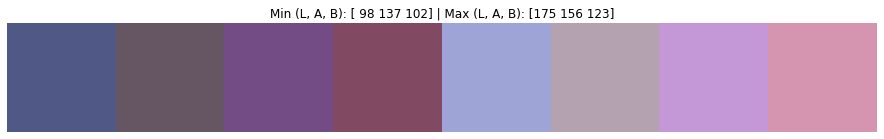

In [6]:
from itertools import product

def plot_min_max_lab_colors(min_vals, max_vals):
    # Generate all combinations of min and max values for L, A, B
    combinations = list(product(*zip(min_vals, max_vals)))
    
    # Normalize and clip Lab values to the 0-255 range
    lab_colors = np.array(combinations, dtype=np.uint8)

    # Convert the Lab values to RGB (or BGR) using OpenCV
    bgr_colors = cv2.cvtColor(lab_colors.reshape(1, 8, 3), cv2.COLOR_LAB2RGB)

    # Plot the 8 colors in a row
    plt.figure(figsize=(18, 2))
    plt.imshow(bgr_colors)
    plt.axis('off')
    plt.title(f"Min (L, A, B): {min_vals} | Max (L, A, B): {max_vals}")
    plt.show()
    
# min and max contain two possible values for L,A, and B
# plot all possible combinations of one L, one A, nad one B
# to visualize the range of colors that are selected by the mask
plot_min_max_lab_colors(min_vals, max_vals)

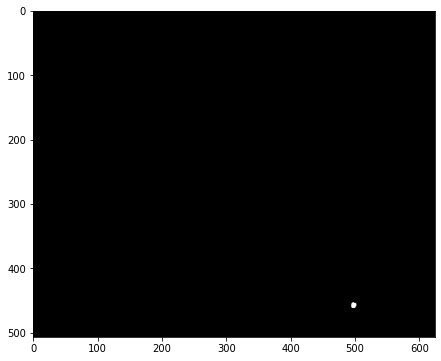

In [7]:
def create_lab_range_mask(frame, min_vals, max_vals):
    # Convert the frame to Lab color space
    lab_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    
    # Create the mask using inRange, which checks each pixel's value within the min and max range for each channel
    # make it be uin64
    lower_bound = np.array(min_vals, dtype=np.uint64)
    upper_bound = np.array(max_vals, dtype=np.uint64)
    
    # Apply the range threshold for L, A, and B channels
    mask = cv2.inRange(lab_frame, lower_bound, upper_bound)
    
    return mask

#scale min values down by 10%
#min_valss = min_vals-10
# decrease second and third values by 10, decrease the first by 20
min_vals_extended = min_vals-10

#scale max values up by 10%
#max_vals_double = max_vals+20
# increase second and third values by 10, increase the first by 20
max_vals_extended = max_vals+10
m = create_lab_range_mask(frame, min_vals_extended, max_vals_extended)
#m = m[0:100,500:600]
show_bgr(m, w=10)
#Min L, A, B values: [121 132  96]
#Max L, A, B values: [194 146  99]
